The following notebook cells have been adapted from the notebook named "1. StyleGAN_Encoder_Notebook" in the Google Drive folder linked below:

https://drive.google.com/drive/folders/1LBWcmnUPoHDeaYlRiHokGyjywIdyhAQb?usp=sharing

Note that the orignal notebook relied on a Git repository which required some modification in order to run at the time this notebook was created (2 years after the original notebook).  Hence, I have forked the original repo and my notebook utilizes my forked repo.

Original repo: https://github.com/pbaylies/stylegan-encoder

My forked repo: https://github.com/buckeye17/stylegan-encoder

In [1]:
# required in order for keras.models.load_model() to work below:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 4.3 MB/s 
     |████████████████████████████████| 15.7 MB 40.1 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

#Make sure the runtime uses a GPU as indicated below:
Runtime --> Change runtime type --> Hardware accelerator: GPU --> Save

In [2]:
# install StyleGAN Encoder
!rm -rf sample_data
!git clone https://github.com/buckeye17/stylegan-encoder.git

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 490 (delta 0), reused 1 (delta 0), pack-reused 487
Receiving objects: 100% (490/490), 12.71 MiB | 12.56 MiB/s, done.
Resolving deltas: 100% (266/266), done.


In [3]:
cd stylegan-encoder

/content/stylegan-encoder


In [4]:
# prepare environment for accepting input images and dumping output images
!rm -rf aligned_images raw_images
!mkdir aligned_images raw_images

#Place images into the raw_images folder as shown below before proceding further
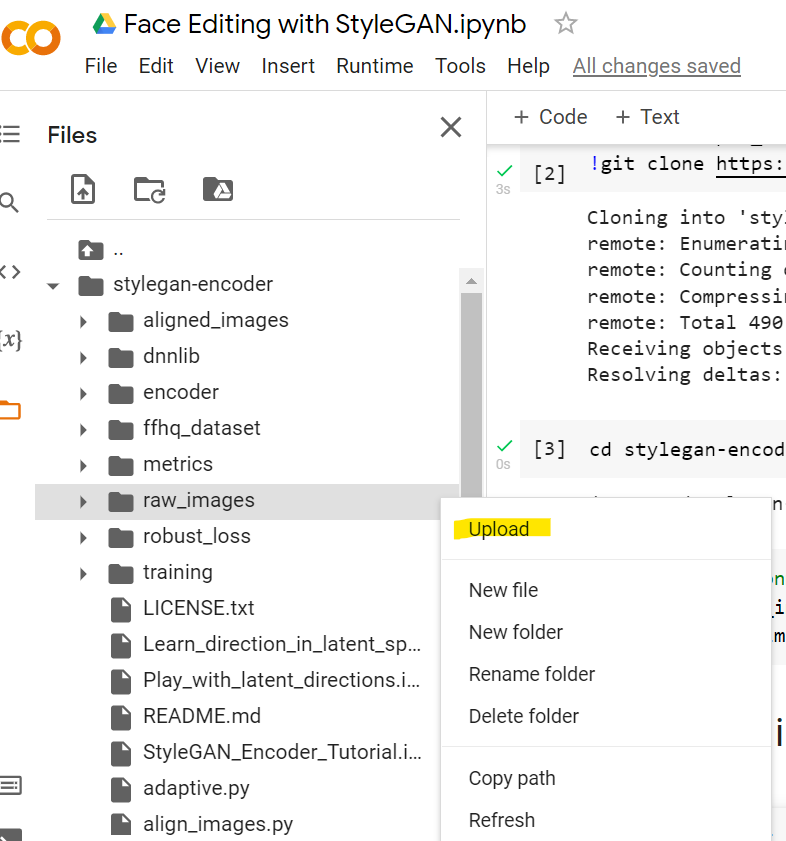

Found 1 images in raw_images
['imaginary_seed.jpg']


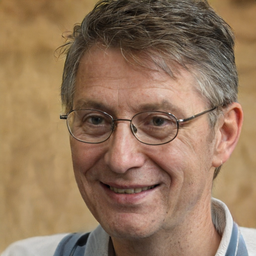

In [5]:
# show the input images
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

TensorFlow 1.x selected.
Using TensorFlow backend.
64045056/64040097 [==============================] - 6s 0us/step
Aligning imaginary_seed.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/imaginary_seed_01.png


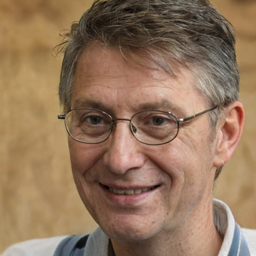

'img 0: imaginary_seed_01.png'

In [6]:
# make aligned images
%tensorflow_version 1.x
import tensorflow as tf

!python align_images.py raw_images/ aligned_images/ --output_size=1024
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

#If any of the above images aren't clear faces, manually delete them from the aligned_images folder

In [7]:
# steup for encoding images in latent space of StyleGAN
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

# Colab's download quota gets exceeded when downloading the following file:
# https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ (filename: karras2019stylegan-ffhq-1024x1024.pkl)
# Therefore encode_image.py has been modified to not download the file anymore
# Either allow Colab to download the file from Google Drive, or manually download
# it from the link and upload it to the cache directory
!mkdir cache
!gdown https://drive.google.com/uc?id=15D_Z6mZyKxUqpE3ptKo17aSEwDqd519p
!mv karras2019stylegan-ffhq-1024x1024.pkl cache

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
100% 330M/330M [00:04<00:00, 80.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=15D_Z6mZyKxUqpE3ptKo17aSEwDqd519p
To: /content/stylegan-encoder/karras2019stylegan-ffhq-1024x1024.pkl
100% 325M/325M [00:04<00:00, 75.8MB/s]


In [8]:
# encode images in latent space of StyleGAN
!python encode_images.py --optimizer=lbfgs --face_mask=True --iterations=6 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")

import dnnlib, pickle
import dnnlib.tflib as tflib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 3s 0us/step
  0% 0/1 [00:00<?, ?it/s]WARNING:tensorflow:From /tensorflow-1.15.2/python3.7/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Saving mask masks/imaginary_seed_01.png
Loading ResNet Model:

  0% 0/6 [00:00<?, ?it/s]WARNING:tensorflow:
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions fo

In [9]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

# generate arbitrary StyleGAN images
# def plot_imgs(model, rows, columns):
#   for i in range(rows):
#     f, axarr = plt.subplots(1,columns, figsize = (20,8))
#     for j in range(columns):
#       img = generate_images(model, np.random.randn(1,512), z = True)[0]
#       axarr[j].imshow(img)
#       axarr[j].axis('off')
#       axarr[j].set_title('Resolution: %s' %str(img.shape))
#     plt.show()
#  
# plot_imgs(averaged_generator_network, 3, 3)

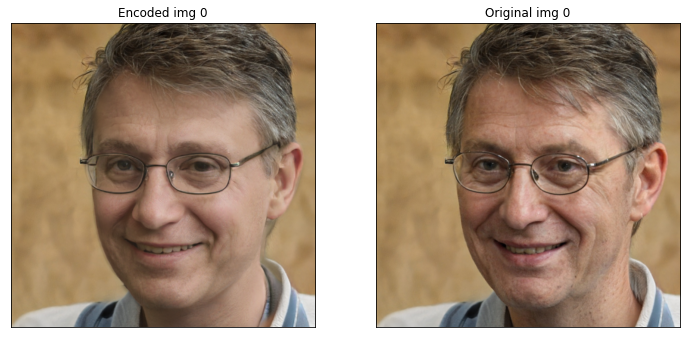

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]

display_sbs('generated_images/', 'aligned_images/', res = 512)

# Let's take a look at the results of our encoding:
### If the results don't look great: Play with the encoding arguments!!!
> 1. Run the optimization for more iterations (eg 500)
> 2. Decrease the L1 penalty (to eg 0.15)
> 3. Try a lower initial learning rate (eg 0.02) or play with the decay_rate
> 4. Find out about the other encoding options here: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py
> 5. You can find a bunch of good presets on the repo documentation: https://github.com/pbaylies/stylegan-encoder

In [11]:
# write the encodings of the good images to a file for further manipulation
import numpy as np
#Change these numbers to pick out latents that worked well (see the image plots)
good_images = [0]
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

1 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


#Setup for manipulating faces
The following notebook cells have been adapted from the notebook named "2. Face_Editing_Notebook" in the Google Drive folder linked below:

https://drive.google.com/drive/folders/1LBWcmnUPoHDeaYlRiHokGyjywIdyhAQb?usp=sharing

Note, this notebook relies on the following Git repository:

https://github.com/tr1pzz/InterFaceGAN

In [12]:
cd ..

/content


In [13]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!echo ****** Cuda reinstall completed. Restart runtime now! *******

!pip install --upgrade tensorflow-gpu==1.15.2

!git clone https://github.com/tr1pzz/InterFaceGAN.git

--2021-11-29 07:46:01--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.39.144
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb [following]
--2021-11-29 07:46:02--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?y3TqT2qD--zk8zghlxzZKX0BfWN5gZizM5H-UrO4Ys8AqSp4aU3XERcVQFbVYP4x-1NwCb-Zn7YIFroFvUprgRETMPFmw

Cloning into 'InterFaceGAN'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 2.06 MiB | 2.77 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [14]:
cp /content/stylegan-encoder/cache/karras2019stylegan-ffhq-1024x1024.pkl /content/InterFaceGAN/models/pretrain/karras2019stylegan-ffhq-1024x1024.pkl

In [15]:
# Configure parameters for manipulating faces
latent_direction = 'eyeglasses'     #### Pick one of ['age', 'eyeglasses', 'gender', 'pose', 'smile']
morph_strength = 1           # Controls how strongly we push the face into a certain latent direction (try 1-5)
nr_interpolation_steps = 3  # The amount of intermediate steps/frames to render along the interpolation path

boundary_file = 'stylegan_ffhq_%s_w_boundary.npy' %latent_direction
print("Ready to start manipulating faces in the ** %s ** direction!" %latent_direction)
print("Interpolation from %d to %d with %d intermediate frames." %(-morph_strength, morph_strength, nr_interpolation_steps))
print("\nLoading latent directions from %s" %boundary_file)

Ready to start manipulating faces in the ** eyeglasses ** direction!
Interpolation from -1 to 1 with 3 intermediate frames.

Loading latent directions from stylegan_ffhq_eyeglasses_w_boundary.npy


In [1]:
cd /content/InterFaceGAN/

/content/InterFaceGAN


In [6]:
# delete the results folder results/[LATENT_DIRECTION]
# !rm -r results/smile

# run the image manipulation
# -b = latent direction, Pick one of ['age', 'eyeglasses', 'gender', 'pose', 'smile']
# -o = results directory
# --start_distance = negative morph strength
# --end_distance = positive morph strength
# --steps = number of interpolation steps
!python edit.py \
  -m stylegan_ffhq \
  -b boundaries/stylegan_ffhq_smile_w_boundary.npy \
  -s Wp \
  -i '/content/output_vectors.npy' \
  -o results/smile \
  --start_distance -1.00 \
  --end_distance 1.00 \
  --steps=3

[2021-11-29 08:06:07,449][INFO] Initializing generator.
[2021-11-29 08:06:07,726][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2021-11-29 08:06:08,028][INFO] Successfully loaded!
[2021-11-29 08:06:10,451][INFO] Preparing boundary.
[2021-11-29 08:06:10,452][INFO] Preparing latent codes.
[2021-11-29 08:06:10,452][INFO]   Load latent codes from `/content/output_vectors.npy`.
[2021-11-29 08:06:10,453][INFO] Editing 1 samples.
[2021-11-29 08:06:11,088][INFO] Successfully edited 1 samples.


If the above cell gives an error, try restarting the runtime and then re-execute the two prior cells beginning with the `cd /content/InterFaceGAN/` cell.

In [18]:
# compare the images
display_sbs('/content/stylegan-encoder/generated_images/', 'results/', res = 512)

Found different amount of images in aligned vs raw image directories. That's not supposed to happen...


IndexError: ignored